In [1]:
from __future__ import unicode_literals
import time, json, requests
from datetime import datetime
import pandas as pd
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt
from fiona.crs import from_epsg,from_string

def catch_distribution():
    """抓取行政区域确诊分布数据"""
    
    data = dict()
    data.update({'prov':[], 'confirm':[], 'color':[]})
    url = 'https://view.inews.qq.com/g2/getOnsInfo?name=disease_h5&callback=&_=%d'%int(time.time()*1000)
    orig_data = json.loads(requests.get(url=url).json()['data'])
    for province in orig_data["areaTree"][0]["children"]:
        name = province['name']
        if name == "内蒙古":
            name += "自治区"
        elif name == "新疆":
            name += "维吾尔自治区"
        elif name == "西藏":
            name += "自治区"
        elif name == "宁夏":
            name += "回族自治区"
        elif name == "广西":
            name += "壮族自治区"
        elif name == "香港" or name == "澳门":
            name += "特别行政区"
        elif name == "北京" or name == "上海" or name == "天津" or name == "重庆":
            name += "市"
        else:
            name += "省"
        data['prov'].append(name)
        total = 0
        for city in province["children"]:
            total += int(city["total"]["confirm"])
        data['confirm'].append(total)
        if total == 0:
            data['color'] = '#f0f0f0'
        elif total < 10:
            data['color'] = '#ffaa85'
        elif total <100:
            data['color'] = '#ff7b69'
        elif  total < 1000:
            data['color'] = '#bf2121'
        else:
            data['color'] = '#7f1818'
    return data

def wgs84_to_CGCS2000(df,code):
    result = df.to_crs(from_epsg(code))
    return result

def plot_distribution():
    data = pd.DataFrame(catch_distribution())
    china_geod = gp.read_file('./res/china-shapefiles-master/china.shp', encoding = 'utf')
    china_pcs = wgs84_to_CGCS2000(china_geod, 4549)

    # 将data转换为geopandas.DataFrame
    data_geod = gp.GeoDataFrame(data)
    # 修改列名
    china_pcs = china_pcs.rename(index = str, columns = {'FCNAME':'prov'})
    # 数据合并（去掉岛屿）
    da_merge = china_pcs.merge(data_geod, on = 'prov', how = 'inner')
    # 画图
    da_merge.plot('confirm', cmap = 'Reds', scheme = 'QUANTILES', k=5, legend = True, figsize = (9, 9),edgecolor='black')

    plt.gca().xaxis.set_major_locator(plt.NullLocator())#去掉x轴刻度
    plt.gca().yaxis.set_major_locator(plt.NullLocator())#去年y轴刻度

/home/jerry/nCoVMap/env/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/jerry/nCoVMap/env/lib/python3.6/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/home/jerry/nCoVMap/env/lib/python3.6/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


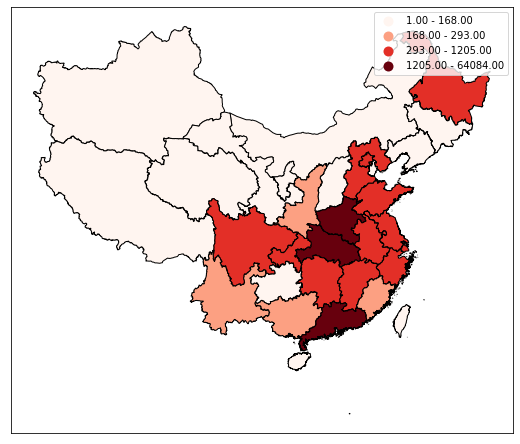

In [2]:
data = plot_distribution()